In [1]:
# setup
import os, math, glob
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd

# paths
FITS_PATH = "../data/raw/M87_EHT_2018_3644_b3.fits"
OUT_DIR = "../data/processed"
os.makedirs(f"{OUT_DIR}/kelvin", exist_ok=True)
os.makedirs(f"{OUT_DIR}/norm", exist_ok=True)

# flare number and distribution
N_NORMAL, N_FLARE = 1000, 200
FLARE_PROBS = {"ring": 0.80, "offring": 0.10, "multi": 0.07, "large": 0.03}

# physics paramaters
RING_RADIUS, MIN_RADIUS = 20.0, 9.0

# full width maximum, how spread out the flare will be
FLARE_FWHM_RANGE = (5.0, 12.0)

# telescope beam shape, pa is position angle
BEAM = {"fwhm_x": 10.0, "fwhm_y": 8.0, "pa": 0.0}

# 1% noise that will be relative to brightness
NOISE_FRACTION = 0.01

# 99.5th percentile value for normalization
NORMALIZATION_PCT = 99.5

In [2]:
# utility functions

# returns squeezed data (1, 1, 128, 128) -> (128, 128)
def load_fits(path):
    with fits.open(path) as hdul:
        return np.squeeze(hdul[0].data), hdul[0].header # squeezing

# converts pixelscale to micro arcseconds
def pixel_scale(hdr):

    # getting the pixel scale from the headers
    c1 = hdr.get("CDELT1", hdr.get("CD1_1"))
    c2 = hdr.get("CDELT2", hdr.get("CD2_2"))
    deg_to_uas = 3600 * 1e6

    # returns pixel scale in (x, y) 
    return abs(c1) * deg_to_uas, abs(c2) * deg_to_uas

# converts full width maximum to gaussian standard deviation
def fwhm_to_sigma(fwhm, px_scale):
    
    # turn into pixel scale then apply the gaussian relationship 
    return (fwhm / px_scale) / (2 * math.sqrt(2 * math.log(2)))

# create an elliptical gaussian blob on a grid
def elliptical_gaussian(nx, ny, cx, cy, sx, sy, theta, amp):
    y, x = np.mgrid[:ny, :nx]       # y = rows, x = cols
    dx, dy = x - cx, y - cy         # distance from center points
    rad = math.radians(theta)                       # convert to radians
    cos_t, sin_t = math.cos(rad), math.sin(rad)     # compute trig values
    xr, yr = cos_t * dx + sin_t * dy, -sin_t * dx + cos_t * dy  # rotation angle by theta angle 
    return amp * np.exp(-0.5 * ((xr/sx)**2 + (yr/sy)**2))       # gaussian formula with the rotated, scaled cords

# blur the image like a telescope would
def convolve_beam(img, beam, px_x, px_y):
    nx, ny = img.shape
    sx = fwhm_to_sigma(beam["fwhm_x"], px_x)
    sy = fwhm_to_sigma(beam["fwhm_y"], px_y)

    # creates a centered gaussian kernel on image
    kernel = elliptical_gaussian(nx, ny, (nx-1)/2, (ny-1)/2, sx, sy, beam["pa"], 1.0)
    kernel /= kernel.sum()                               # quick normalization
    
    fft_img = np.fft.rfft2(img)                          # fast fourier transform of image 
    fft_kernel = np.fft.rfft2(np.fft.ifftshift(kernel))  # fast fourier transform of kernel

    # multiplies in fourier space to apply blur then inverts the transform to original image
    return np.fft.irfft2(fft_img * fft_kernel, s=img.shape)

# just normalizes images on a [0, 1] scale
def normalize(img, global_max=None):
    if global_max is None:
        # if there isn't a global max use the image inputted for it
        return np.clip(img / np.percentile(img, NORMALIZATION_PCT), 0, 1)
    else:
        # use provided global max for normalization 
        return np.clip(img / global_max, 0, 1)

# saves both kelvin and normalized images
def save_pair(img_K, img_id, global_max=None):
    np.save(f"{OUT_DIR}/kelvin/{img_id}.npy", img_K)    # save kelvin
    norm_id = img_id.replace("_K", "_norm")             # replace _K with _norm filename
    img_norm = normalize(img_K, global_max=global_max)  # normalizes the image
    np.save(f"{OUT_DIR}/norm/{norm_id}.npy", img_norm)  # save normalized

In [3]:
# flare sampling functions

# getting the bright region reference for scaling flare amplititudes
def crescent_peak(img):
    return np.percentile(img, 98)

# generates a flare on the accretion/emission disk
def sample_ring_flare(img, hdr, px_x, px_y):
    # get images center cords
    nx, ny = img.shape
    cx0, cy0 = (nx-1)/2, (ny-1)/2
    
    # sample the radial distance with the gaussian distribution (goated), in this case its constrained to [18, 22]
    target, sigma_r = RING_RADIUS, 1.2
    while True:
        r_uas = np.random.normal(target, sigma_r)
        if 18.0 <= r_uas <= 22.0:
            break

    # convert radius from micro arcseconds to pixels
    r_px = r_uas / px_x
    
    # sample angular posistion with bias towards the crescent (bottom right)
    crescent_angle = -45.0
    while True:
        theta = np.random.uniform(-180, 180)
        if np.random.rand() < np.exp(1.5 * (math.cos(math.radians(theta - crescent_angle)) - 1)):
            break

    # convert polar based cords (r, θ) to (x, y)
    cx, cy = cx0 + r_px * math.cos(math.radians(theta)), cy0 + r_px * math.sin(math.radians(theta))

    # random flare between 5-12 micro arcseconds
    fwhm = np.random.uniform(*FLARE_FWHM_RANGE)

    # convert to sigma, with the y-axis randomly compressed to give it that elliptical shape
    sx, sy = fwhm_to_sigma(fwhm, px_x), fwhm_to_sigma(fwhm, px_y) * np.random.uniform(0.6, 1.0)

    # random rotation angle
    theta_deg = np.random.uniform(0, 180)
    

    peak = crescent_peak(img)
    # get flare posistion as integer indices (clipped to image bounds)
    ix, iy = int(np.clip(cx, 0, nx-1)), int(np.clip(cy, 0, ny-1))
    
    # scale amplitude on local brightness (brighter regions get brigher flares)
    local_factor = max(0.9, 0.8 + 0.4 * (img[iy, ix] / (peak + 1e-12)))

    # convert to kelvin
    amp = peak * np.random.uniform(1.0, 1.5) * local_factor * 1e9
    
    return cx, cy, sx, sy, theta_deg, amp

# generates offring flares anywhere in the image 
def sample_offring_flare(img, hdr, px_x, px_y):
    nx, ny = img.shape
    # find margin to avoid edges
    margin = int(max(4, 5.0 / px_x))
    cx, cy = np.random.uniform(margin, nx-1-margin), np.random.uniform(margin, ny-1-margin)
    
    # slightly wider width (5, 14) as compared to ring flares
    fwhm = np.random.uniform(5.0, 14.0)
    sx, sy = fwhm_to_sigma(fwhm, px_x), fwhm_to_sigma(fwhm, px_y) * np.random.uniform(0.7, 1.0)
    theta_deg = np.random.uniform(0, 180)
    
    peak = crescent_peak(img)
    ix, iy = int(np.clip(cx, 0, nx-1)), int(np.clip(cy, 0, ny-1))
    local_factor = 0.7 + 0.6 * (img[iy, ix] / (peak + 1e-12))
    
    # much dimmer than ring flares
    amp = peak * np.random.uniform(0.08, 0.65) * local_factor * 1e9
    
    return cx, cy, sx, sy, theta_deg, amp

# larger, more extended vrsion of ring flare
def sample_large_flare(img, hdr, px_x, px_y):
    cx, cy, sx, sy, theta_deg, _ = sample_ring_flare(img, hdr, px_x, px_y)
    
    # enlarging the flare
    size_factor = np.random.uniform(1.3, 1.8)
    sx, sy = sx * size_factor, sy * size_factor
    
    peak = crescent_peak(img)
    amp = peak * np.random.uniform(1.2, 1.5) * 1e9  # reduced max
    
    return cx, cy, sx, sy, theta_deg, amp

In [4]:
# adds the flares to the blackhole image
def inject_flares(base_img, hdr, n_flares, flare_type, beam):
    px_x, px_y = pixel_scale(hdr)
    # create an empty array for accumulating flares 
    flare_layer = np.zeros_like(base_img)
    
    for _ in range(n_flares):
        sampler = {
            "ring": sample_ring_flare,
            "offring": sample_offring_flare,
            "large": sample_large_flare
        }[flare_type]
        
        cx, cy, sx, sy, theta_deg, ampK = sampler(base_img, hdr, px_x, px_y)
        
        # add the gaussian flare
        flare_layer += elliptical_gaussian(*base_img.shape, cx, cy, sx, sy, theta_deg, ampK / 1e9)
    
    # adding the blurred flares
    flare_blurred = convolve_beam(flare_layer, beam, px_x, px_y)
    return base_img + flare_blurred

In [5]:
# main dataset generation pipeline
def generate_dataset():
    img_fits, hdr = load_fits(FITS_PATH)
    px_x, px_y = pixel_scale(hdr)
    
    # blur the image with base telescope beam
    img_fits_blurred = convolve_beam(img_fits, BEAM, px_x, px_y)
    base_K = np.clip(img_fits_blurred * 1e9, 0, None)
    
    # flare counts
    counts = {k: int(N_FLARE * v) for k, v in FLARE_PROBS.items()}  # status check
    counts["large"] = N_FLARE - sum(v for k, v in counts.items() if k != "large")
    print(f"Generating {N_NORMAL} normal + {N_FLARE} flare images...")
    
    # collect all kelvin images in a dictionary
    images_K = {}
    np.random.seed(67)  # bohahaha
    noise_sigma = NOISE_FRACTION * base_K.max() # noise level will be 1% of peak brightness
    
    # normal images
    for i in range(N_NORMAL):
        noise = np.random.normal(0, noise_sigma, base_K.shape)
        img_K = np.clip(base_K + noise, 0, None)
        images_K[f"normal_{i:04d}_K"] = img_K
    
    # flare images
    idx = 0
    for flare_type, count in counts.items():
        for _ in range(count):
            n_hot = 1
            if flare_type == "multi":
                n_hot = np.random.choice([2,3], p=[0.7,0.3])    # for multi-flares chooses 2 (70%) or 3 (30%) flares
            
            # multi uses ring sampler, which is an oversight as it doesn't include possibilities of an offring or large flare
            sampler_type = "ring" if flare_type == "multi" else flare_type
            
            # inject the flares into the blurred base
            img_fits_out = inject_flares(img_fits_blurred, hdr, n_hot, sampler_type, BEAM)
            img_K = np.clip(img_fits_out * 1e9, 0, None)
            
            # add noise
            noise = np.random.normal(0, noise_sigma, img_K.shape)
            img_K = np.clip(img_K + noise, 0, None)
            
            prefix = f"flare_{flare_type}_{idx:04d}_K"
            images_K[prefix] = img_K
            idx += 1
    
    # global normalization
    all_images = np.array(list(images_K.values()))  # put all images into a single array
    global_max = np.percentile(all_images, NORMALIZATION_PCT)   # get the brightest portions of each (99.5th percentile)
    print(f"\nGlobal max: {global_max:.1e} K")
    
    # save
    for img_id, img_K in images_K.items():
        save_pair(img_K, img_id, global_max=global_max)
    
    # summary
    summary = pd.DataFrame([
        {"class": "normal", "count": N_NORMAL},
        {"class": "flare_ring", "count": counts["ring"]},
        {"class": "flare_offring", "count": counts["offring"]},
        {"class": "flare_multi", "count": counts["multi"]},
        {"class": "flare_large", "count": counts["large"]},
    ])
    summary.to_csv(f"{OUT_DIR}/dataset_summary.csv", index=False)
    print("\nDataset summary:")
    print(summary)
    return summary

summary = generate_dataset()

Generating 1000 normal + 200 flare images...

Global max: 6.8e+09 K

Dataset summary:
           class  count
0         normal   1000
1     flare_ring    160
2  flare_offring     20
3    flare_multi     14
4    flare_large      6


=== Final Dataset Statistics ===
Loading 1200 Kelvin files for global normalization...
Global min: 0.0e+00 K, max: 6.8e+09 K

Global 99.5th percentile: 6.8e+09 K

Shadow depth (global norm):
  Base:   0.3055
  Normal: 0.2744 (Δ = -0.0311)
  Flare:  0.2867 (Δ = -0.0187)

Verdict:
  Normal: ✓ PASS
  Flare:  ✓ PASS


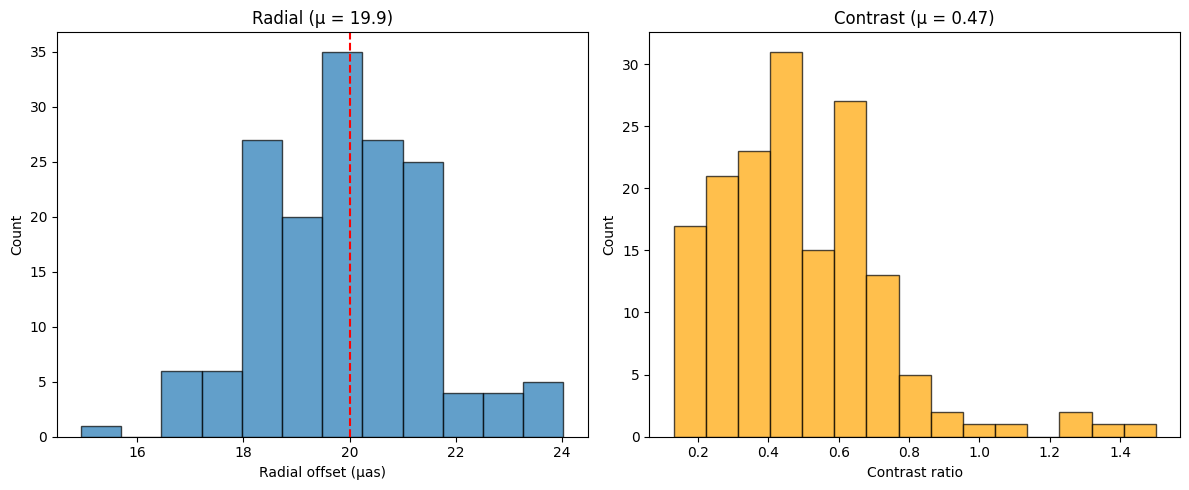


Ring flares:
  on_ring: 141/160 => 88.1%
  peak histogram: 19.9 ± 1.6 μas
  median contrast: 0.47x
  faint flares (<0.25×): 21

Median peak brightness:
  ring        : ~9.3e+09 K
  offring     : ~7.2e+09 K
  large       : ~1.1e+10 K


In [6]:
# AI coded graphs for visualization check

def get_global_norm_factor(out_dir):
    # Use glob to find ALL Kelvin files (not just base)
    kelvin_files = glob.glob(f"{out_dir}/kelvin/*_K.npy")
    
    if not kelvin_files:
        raise FileNotFoundError(f"No Kelvin files found in {out_dir}/kelvin/")
    
    all_images = []
    print(f"Loading {len(kelvin_files)} Kelvin files for global normalization...")
    for f in kelvin_files:
        img = np.load(f)
        all_images.append(img)
    
    all_images = np.array(all_images)
    global_max = np.percentile(all_images, NORMALIZATION_PCT)
    global_min = all_images.min()
    print(f"Global min: {global_min:.1e} K, max: {global_max:.1e} K")
    return global_max

def run_diagnostics(fits_path, out_dir, ring_radius):
    """Verify consistency with global normalization."""
    img_raw, hdr = load_fits(fits_path)
    px = pixel_scale(hdr)[0]
    cx, cy = (img_raw.shape[1]-1)/2, (img_raw.shape[0]-1)/2
    base_K = img_raw * 1e9
    
    global_max = get_global_norm_factor(out_dir)
    print(f"\nGlobal 99.5th percentile: {global_max:.1e} K")
    
    base_files = glob.glob(f"{out_dir}/kelvin/base*.npy")
    normal_files = glob.glob(f"{out_dir}/kelvin/normal_0000_K.npy")
    ring_files = glob.glob(f"{out_dir}/kelvin/flare_ring_0000_K.npy")
    
    if not all([base_files, normal_files, ring_files]):
        print("Warning: Some sample files missing, using first available...")
        kelvin_files = glob.glob(f"{out_dir}/kelvin/*.npy")
        if len(kelvin_files) < 3:
            print("Not enough files generated yet!")
            return
        
        base_norm = np.load(kelvin_files[0]) / global_max
        normal_norm = np.load(kelvin_files[1]) / global_max
        ring_norm = np.load(kelvin_files[2]) / global_max
    else:
        base_norm = np.load(base_files[0]) / global_max
        normal_norm = np.load(normal_files[0]) / global_max
        ring_norm = np.load(ring_files[0]) / global_max
    
    cy_coord, cx_coord = (np.array(base_norm.shape) - 1) // 2
    base_shadow = base_norm[cy_coord, cx_coord]
    normal_shadow = normal_norm[cy_coord, cx_coord]
    ring_shadow = ring_norm[cy_coord, cx_coord]
    
    print(f"\nShadow depth (global norm):")
    print(f"  Base:   {base_shadow:.4f}")
    print(f"  Normal: {normal_shadow:.4f} (Δ = {normal_shadow-base_shadow:+.4f})")
    print(f"  Flare:  {ring_shadow:.4f} (Δ = {ring_shadow-base_shadow:+.4f})")
    
    tolerance = 0.05
    normal_ok = abs(normal_shadow - base_shadow) < tolerance
    flare_ok = abs(ring_shadow - base_shadow) < tolerance
    
    print(f"\nVerdict:")
    print(f"  Normal: {'✓ PASS' if normal_ok else '⚠️ FAIL'}")
    print(f"  Flare:  {'✓ PASS' if flare_ok else '⚠️ FAIL'}")
    
    ring_files = sorted(glob.glob(f"{out_dir}/kelvin/flare_ring_*_K.npy"))
    if not ring_files:
        print("No ring flare files found for radial analysis")
        return
    
    radii, contrasts = [], []
    for f in ring_files:
        combined_K = np.load(f)
        flare_only = combined_K - base_K
        iy, ix = np.unravel_index(np.argmax(flare_only), flare_only.shape)
        r = np.sqrt(((ix-cx)*px)**2 + ((iy-cy)*px)**2)
        radii.append(r)
        
        base_val = base_K[iy, ix]
        flare_val = flare_only[iy, ix]
        contrasts.append(flare_val / base_val)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.hist(radii, bins=12, edgecolor='black', alpha=0.7)
    plt.axvline(ring_radius, c='r', ls='--')
    plt.xlabel("Radial offset (μas)"); plt.ylabel("Count")
    plt.title(f"Radial (μ = {np.mean(radii):.1f})")
    
    plt.subplot(122)
    plt.hist(contrasts, bins=15, edgecolor='black', alpha=0.7, color='orange')
    plt.xlabel("Contrast ratio"); plt.ylabel("Count")
    plt.title(f"Contrast (μ = {np.median(contrasts):.2f})")
    plt.tight_layout(); plt.show()
    
    tolerance = 2.5
    on_ring = sum(abs(r - ring_radius) <= tolerance for r in radii)
    print(f"\nRing flares:")
    print(f"  on_ring: {on_ring}/{len(radii)} => {100.0 * on_ring / len(radii):.1f}%")
    print(f"  peak histogram: {np.mean(radii):.1f} ± {np.std(radii):.1f} μas")
    print(f"  median contrast: {np.median(contrasts):.2f}x")
    
    faint = sum(c < 0.25 for c in contrasts)
    print(f"  faint flares (<0.25×): {faint}")
    
    print("\nMedian peak brightness:")
    for pattern, label in [("flare_ring", "ring"), ("flare_offring", "offring"), ("flare_large", "large")]:
        files = sorted(glob.glob(f"{out_dir}/kelvin/{pattern}_*.npy"))
        if files:
            med = np.median([np.load(f).max() for f in files])
            print(f"  {label:12s}: ~{med:.1e} K")

print("=== Final Dataset Statistics ===")
run_diagnostics(FITS_PATH, OUT_DIR, RING_RADIUS)